In [1]:
import numpy as np
import scipy as sp
import h5py
import json
import time
import types
import math
import matplotlib
import functions as fs
import matplotlib
from scipy. integrate import odeint


from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import display, HTML, Markdown, Math, Latex

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
matplotlib.rcParams['font.family'] = 'serif'  # Установка семейства шрифта
# выставляем большой шрифт на картинках по умолчанию
font = {"size": 12}
matplotlib.rc("font", **font)

%matplotlib inline

au_to_fs = 2.4*10**(-17)*10**15

from IR import IR

In [2]:
def plot(t_arr, n_arr, colors = None, figsize=(4, 3), yscale="log", xlim = None, ylim = [1e-5, 1], title=None):
    fig, ax = plt.subplots(1, 1, figsize=figsize, layout="constrained")
    for i in range(len(n_arr)):
        if colors:
            ax.plot(t_arr[i], n_arr[i], color=colors[i], linestyle = '-')
        else:
            ax.plot(t_arr[i], n_arr[i], linestyle = '-')
    ax.grid();  
    if title:
        ax.set_title(title)
    if ylim:
        ax.set_ylim(ylim);
    if xlim:
        ax.set_xlim(xlim);
    if yscale:
        ax.set_yscale(yscale)
    return fig, ax

In [3]:
def KinEqs_single_ionization(t_arr, n_init, w1):
    KE = lambda n, t:np.array([
                -w1(t)*n[0],
                w1(t)*n[0]
    ]) 
    n = odeint(KE, n_init, t_arr)
    return n

# Трехмерный одноэлектронный гелий He3d

In [4]:
w_He = IR(I = fs.eV_to_au(24.58738), Z=1, l=0, m=0, A=2.87)
w_He.set_alpha(7)  # для TongLin 

In [5]:
# задаем поле
E0 = 0.16
omega = 0.01
T = np.pi/omega

def E(t):
    E = E0 * np.sin(omega * t) ** 2 * \
        np.heaviside(np.pi / omega - t, 0)
    return E
    
# устанавливаем поле
w_He.set_Et(E)

In [6]:
#Решаем скоростные уравнения
time_indent = 0.25
t_arr = np.linspace(time_indent*T, (1-time_indent)*T, 100)
n_He_PPT = KinEqs_single_ionization(t_arr, [1,0], w_He.get_wt_PPT)
n_He_TongLin = KinEqs_single_ionization(t_arr, [1,0], w_He.get_wt_TongLin)
print(f"PPT    : n0={n_He_PPT[-1,0]:.4f}, n1={n_He_PPT[-1,1]:.4f}")
print(f"TongLin: n0={n_He_TongLin[-1,0]:.4f}, n1={n_He_TongLin[-1,1]:.4f}")

PPT    : n0=0.9596, n1=0.0404
TongLin: n0=0.9750, n1=0.0250


In [7]:
# Поле, при котором барьер пригибается
# ниже потенциала ионизации дл He:
# Ecr=0.2 

# E0=0.19 omega=0.02 ===> Ecr/E0=0.95 gamma=0.14
# PPT     n0   : 0.9033
# TongLin n0   : 0.9444
# Numeric norm2: 0.9379

# E0=0.19 omega=0.01 ===> Ecr/E0=0.95 gamma=0.07
# PPT     n0   : 0.8106
# TongLin n0   : 0.8920
# Numeric norm2: 0.8830

# E0=0.16 omega=0.01 ===> Ecr/E0=0.8 gamma=0.07
# PPT     n0   : 0.9596
# TongLin n0   : 0.9750
# Numeric norm2: 0.9718

# E0=0.25 omega=0.02 ===> Ecr/E0=1.25 gamma=0.11 !!! Надбарьерный режим !!!
# PPT     n0   : 0.4570
# TongLin n0   : 0.6901
# Numeric norm2: 0.6576 

# 1D сглаженный кулон

In [7]:
def atom_potential(x, z, a):
    return z/(np.abs(x)+a)

# x = np.linspace(-10, 10, 1000)
# plt.plot(x, atom_potential(x, -1, 0.5))

In [8]:
def E(t, E0, omega):
    # T = np.pi/omega
    # if t<T:
    return E0*np.sin(omega*t)**2
    # else:
        # return 0.0
E = np.vectorize(E)

In [9]:
def KinEqs(t_arr, n_init, E0, omega, w1, w2):
    
    KE = lambda n, t:np.array([
                -w1.get_w_PPT(E(t, E0, omega))*n[0],
                w1.get_w_PPT(E(t, E0, omega))*n[0] - w2.get_w_PPT(E(t, E0, omega))*n[1],
                w2.get_w_PPT(E(t, E0, omega))*n[1]
    ]) 
    
    n = odeint(KE, n_init, t_arr)
    
    return n

In [10]:
def KinEqs_1d_coulomb(t_arr, n_init, E0, omega, w1, w2):
    
    KE = lambda n, t:np.array([
                -w1.get_w_1d_coulomb(E(t, E0, omega))*n[0],
                w1.get_w_1d_coulomb(E(t, E0, omega))*n[0] - w2.get_w_1d_coulomb(E(t, E0, omega))*n[1],
                w2.get_w_1d_coulomb(E(t, E0, omega))*n[1]
    ]) 
    
    n = odeint(KE, n_init, t_arr)
    
    return n

In [11]:
def KinEqs_1d_short_coulomb(t_arr, n_init, E0, omega, w1, w2):
    
    KE = lambda n, t:np.array([
                -w1.get_w_1d_short(E(t, E0, omega))*n[0],
                w1.get_w_1d_short(E(t, E0, omega))*n[0] - w2.get_w_1d_coulomb(E(t, E0, omega))*n[1],
                w2.get_w_1d_coulomb(E(t, E0, omega))*n[1]
    ]) 
    
    n = odeint(KE, n_init, t_arr)
    
    return n

In [12]:
def KinEqs_1d_coulomb_single_ionization(t_arr, n_init, E0, omega, w):
    
    KE = lambda n, t:np.array([
                -w.get_w_1d_coulomb(E(t, E0, omega))*n[0],
                w.get_w_1d_coulomb(E(t, E0, omega))*n[0]
    ]) 
    
    n = odeint(KE, n_init, t_arr)
    
    return n

In [13]:
def KinEqs_1d_short_single_ionization(t_arr, n_init, E0, omega, w):
    
    KE = lambda n, t:np.array([
                -w.get_w_1d_short(E(t, E0, omega))*n[0],
                w.get_w_1d_short(E(t, E0, omega))*n[0]
    ]) 
    
    n = odeint(KE, n_init, t_arr)
    
    return n

In [14]:
def KinEq_only_n0n1(t_arr, n_init, E0, omega, w1):
    
    KE = lambda n, t:np.array([
                -w1.get_w_PPT(E(t, E0, omega))*n[0],
                w1.get_w_PPT(E(t, E0, omega))*n[0]
    ]) 
    
    n = odeint(KE, n_init, t_arr)
    
    return n

# br

In [15]:
Ip_inner = 11.81; A1 = 1
Ip_external = 3.37; A2 = 1
C_inner_fit_1d_coulomb = 0.857510464
C_external_fit_1d_short = 0.7443286218

w_external = IR(I = fs.eV_to_au(Ip_external), Z=0, l=0, m=0, A=A1)
w_external.set_C_fit_1d_short(C_external_fit_1d_short)

w_inner = IR(I = fs.eV_to_au(Ip_inner), Z=1, l=0, m=0, A=A1)
w_inner.set_C_fit_1d_coulomb(C_inner_fit_1d_coulomb)

E0 = 0.035
omega = 0.04

print("1D_w_external: ", w_external.get_w_1d_short(E0))
print("1D_w_inner:    ", w_inner.get_w_1d_coulomb(E0))

print(f"\nIp_external: {fs.eV_to_au(Ip_external)} au")
print(f"Ip_inner   : {fs.eV_to_au(Ip_inner)} au\n")

Nt = 100
T = np.pi/omega
t_arr = np.linspace(0.01*T, 0.99*T, Nt)

n = KinEqs_1d_coulomb_single_ionization(t_arr, [1, 0], E0, omega, w_inner)
print("W_inner_last=", n[:, 1][-1])

n = KinEqs_1d_short_single_ionization(t_arr, [1, 0], E0, omega, w_external)
print("W_external_last=", n[:, 1][-1])

n = KinEqs_1d_short_coulomb(t_arr, [1, 0, 0], E0, omega, w_external, w_inner)
print("DOUBLE_w_exter=", n[:,1][-1], "\nDOUBLE_w_inner=", n[:,2][-1])

# numerical double
t_num = np.load("/home/denis/elf_home/model_atoms/br_E=0.035_w=0.04_env=50/int_wf2e1d/time_evol/t.npy")
with h5py.File("/home/denis/elf_home/model_atoms/br_E=0.035_w=0.04_env=50/int_wf2e1d/ioniz_prob.hdf5", "r") as f:
    n_num_int = f["ioniz_prob_4"][:]

with h5py.File("/home/denis/elf_home/model_atoms/br_E=0.035_w=0.04_env=50/sym_nonint_wf2e1d/ioniz_prob.hdf5", "r") as f:
    n_num_nonint = f["ioniz_prob_4"][:]

fig, ax = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [2.3, 1]})
fig.subplots_adjust(hspace=0)
ax[0].plot(t_arr*au_to_fs, n[:, 1], color='black', label=r'$n_1$ rate eq.', linestyle = '-')
ax[0].plot(t_arr*au_to_fs, n[:, 2], color='black', label=r'$n_2$ rate eq.', linestyle = '--')
ax[0].plot(t_num*au_to_fs, n_num_int, color='red', label=r'$n_2$ interact', linestyle = '-')
ax[0].plot(t_num*au_to_fs, n_num_nonint, color='green', label=r'$n_2$ non-int', linestyle = '-')
ax[0].grid(); ax[0].legend(loc='lower right');
ax[0].set_title(r"$E_0 = $"+f"{E0}"+r"$~~~~~T = $"+f"{T*au_to_fs:.2f}"+"fs")
ax[0].set_yscale('log')
ax[0].set(xlabel=r'$t$[fs]')
ax[0].set_ylim([1e-7, 5])
ax[0].set_xlim([0, 7])
ax[0].axhline(n[-1,2], linestyle="--", linewidth=1, color = "black")

ax[1].plot(t_num*au_to_fs, E(t_num, E0, omega), color='blue', label=r'$E$', linestyle = '-')
ax[1].set(xlabel=r'$t$[fs]')
# ax[1, 0].set_xticks([0, 10, 20, 30])
ax[1].set_yticks([])
ax[1].grid(); ax[1].legend();

1D_w_external:  0.026347015999378623
1D_w_inner:     0.0006101011485770201

Ip_external: 0.12384653994770284 au
Ip_inner   : 0.43401413554373014 au

W_inner_last= 0.007120796566659662
W_external_last= 0.48038416350253865
DOUBLE_w_exter= 0.47842697910408877 
DOUBLE_w_inner= 0.001957161460704856


FileNotFoundError: [Errno 2] No such file or directory: '/home/denis/elf_home/model_atoms/br_E=0.035_w=0.04_env=50/int_wf2e1d/time_evol/t.npy'

omega= 0.0018849555921538759
W_inner_last= 0.1407080075794731
W_external_last= 0.9999990811204256
DOUBLE_w_exter= 0.8605446893125216 
DOUBLE_w_inner= 0.13945438611297578


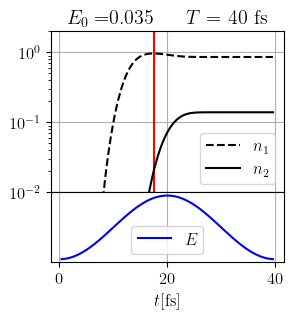

In [24]:
# Короткий импульс
Nt=1000
Tfs = 40
T = Tfs/au_to_fs
E0=0.035
omega=np.pi/T
print("omega=", omega)
t_arr = np.linspace(0.01*T, 0.99*T, Nt)

n = KinEqs_1d_coulomb_single_ionization(t_arr, [1, 0], E0, omega, w_inner)
print("W_inner_last=", n[:, 1][-1])

n = KinEqs_1d_short_single_ionization(t_arr, [1, 0], E0, omega, w_external)
print("W_external_last=", n[:, 1][-1])

n = KinEqs_1d_short_coulomb(t_arr, [1, 0, 0], E0, omega, w_external, w_inner)
print("DOUBLE_w_exter=", n[:,1][-1], "\nDOUBLE_w_inner=", n[:,2][-1])

ind_max_n1 = np.argmax(n[:, 1])

fig, ax = plt.subplots(2, 1, figsize=(3, 3), gridspec_kw={'height_ratios': [2.3, 1]})
fig.subplots_adjust(hspace=0)
ax[0].axvline(t_arr[ind_max_n1]*au_to_fs, linestyle='-', color='red')
ax[0].plot(t_arr*au_to_fs, n[:, 1], color='black', label=r'$n_1$', linestyle = '--')
ax[0].plot(t_arr*au_to_fs, n[:, 2], color='black', label=r'$n_2$', linestyle = '-')
ax[0].grid(); ax[0].legend(loc='lower right');
ax[0].set_title(r"$E_0 = $"+f"{E0}"+r"$~~~~~T = $"+f" {Tfs}"+" fs")
ax[0].set_yscale('log')
ax[1].set(xlabel=r'$t$[fs]')
ax[0].set_ylim([1e-2, 2])
ax[1].plot(t_arr*au_to_fs, E(t_arr, E0, np.pi/T), color='blue', label=r'$E$', linestyle = '-')
# ax[1, 0].set_xticks([0, 10, 20, 30])
ax[1].set_yticks([])
ax[1].grid(); ax[1].legend();
# fig.savefig("RateEq2fs.png", dpi=600,  bbox_inches='tight')

In [18]:
0.035/0.00188

18.617021276595747

# В статью Fig3 Трехмерный new

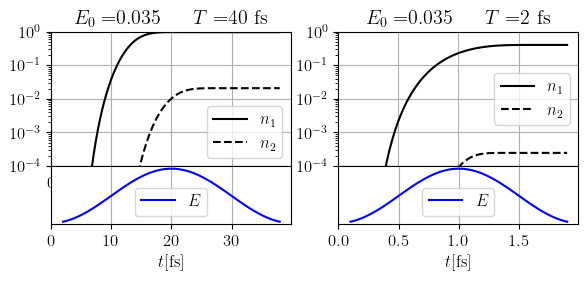

In [20]:
Ip_external = 3.37; A1 = 1.49
Ip_inner = 11.81; A2 = 1.83
w1 = IR(I = fs.eV_to_au(Ip_external), Z=0, l=1, m=0, A=A1)
w2 = IR(I = fs.eV_to_au(Ip_inner), Z=1, l=1, m=0, A=A2)

Ts = np.array([40, 2])
T = Ts/au_to_fs
omegas = np.pi/T
E0s = [0.035, 0.035]
Nt = 100

# задаем поле
def E(t, E0, omega):
    E = E0 * np.sin(omega * t) ** 2 * \
        np.heaviside(np.pi / omega - t, 0)
    return E


# fig, ax = plt.subplots(2, 2, figsize=(6.8, 3.5), gridspec_kw={'height_ratios': [2.3, 1]})
fig, ax = plt.subplots(2, 2, figsize=(6.8, 2.5), gridspec_kw={'height_ratios': [2.3, 1]})
fig.subplots_adjust(hspace=0)

for i in range(2):
    omega = omegas[i]
    E0 = E0s[i]
    T = np.pi/omega
    t_arr = np.linspace(0.05*T, 0.95*T, Nt)
   
    #---------------
    m = 0
    # n = KinEqs(t_arr, [1, 0, 0], E0, omega,  w1, w2)
    n = KinEqs(t_arr, [1, 0, 0], E0, omega,  w1, w2)
    ax[0, i].plot(t_arr*au_to_fs, n[:, 1], color='black', label=r'$n_1$', linestyle = '-')
    ax[0, i].plot(t_arr*au_to_fs, n[:, 2], color='black', label=r'$n_2$', linestyle = '--')
    ax[0, i].grid(); 
    ax[0, i].set_title(r"$E_0 = $"+f"{E0}"+r"$~~~~~T = $"+f"{Ts[i]}"+" fs")
    ax[0, i].set_yscale('log')
    ax[0, i].set(xlabel=r'$t$[fs]')
    ax[0, 0].set_ylim([1e-4, 1])
    ax[0, 1].set_ylim([1e-4, 1])

    ax[1, i].plot(t_arr*au_to_fs, E(t_arr, E0, omega), color='blue', label=r'$E$', linestyle = '-')
    ax[1, i].set(xlabel=r'$t$[fs]')
    ax[i, 0].set_xticks([0, 10, 20, 30])
    ax[i, 1].set_xticks([0.0, 0.5, 1.0, 1.5])
    ax[1, 0].set_yticks([])
    ax[1, 1].set_yticks([])
    ax[1, i].grid(); ax[1, i].legend();

    # if i==1:
    #     # сохранение массивов для статьи
    #     root_data = "/home/denis/MEPhI/Аспирантура/Моя_статья/data"
        
    #     np.save(root_data + "/Fig3/n1_plot_b.npy", n[:, 1])
    #     np.save(root_data + "/Fig3/n2_plot_b.npy", n[:, 2])
    #     np.save(root_data + "/Fig3/t_plot_b.npy", t_arr*au_to_fs)
    #     np.save(root_data + "/Fig3/E_plot_b.npy", E(t_arr, E0, omega))

ax[0, 1].legend(loc='center right');
ax[0, 0].legend(loc='lower right');
    
fig.savefig('Fig3_new.png', bbox_inches='tight', dpi=600)

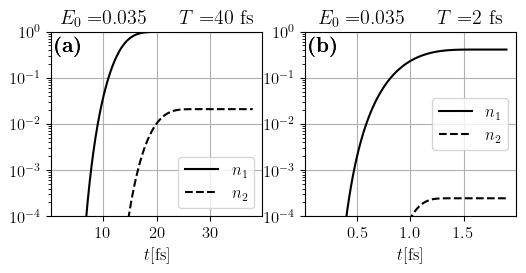

In [25]:
Ip_external = 3.37; A1 = 1.49
Ip_inner = 11.81; A2 = 1.83
w1 = IR(I = fs.eV_to_au(Ip_external), Z=0, l=1, m=0, A=A1)
w2 = IR(I = fs.eV_to_au(Ip_inner), Z=1, l=1, m=0, A=A2)

Ts = np.array([40, 2])
T = Ts/au_to_fs
omegas = np.pi/T
E0s = [0.035, 0.035]
Nt = 100

# задаем поле
def E(t, E0, omega):
    E = E0 * np.sin(omega * t) ** 2 * \
        np.heaviside(np.pi / omega - t, 0)
    return E


# fig, ax = plt.subplots(2, 2, figsize=(6.8, 3.5), gridspec_kw={'height_ratios': [2.3, 1]})
fig, ax = plt.subplots(1, 2, figsize=(6, 2.4))
fig.subplots_adjust(hspace=0)

for i in range(2):
    omega = omegas[i]
    E0 = E0s[i]
    T = np.pi/omega
    t_arr = np.linspace(0.05*T, 0.95*T, Nt)
   
    #---------------
    m = 0
    # n = KinEqs(t_arr, [1, 0, 0], E0, omega,  w1, w2)
    n = KinEqs(t_arr, [1, 0, 0], E0, omega,  w1, w2)
    ax[ i].plot(t_arr*au_to_fs, n[:, 1], color='black', label=r'$n_1$', linestyle = '-')
    ax[ i].plot(t_arr*au_to_fs, n[:, 2], color='black', label=r'$n_2$', linestyle = '--')
    ax[ i].grid(); 
    ax[ i].set_title(r"$E_0 = $"+f"{E0}"+r"$~~~~~T = $"+f"{Ts[i]}"+" fs")
    ax[ i].set_yscale('log')
    ax[ i].set(xlabel=r'$t$[fs]')
    ax[ 0].set_ylim([1e-4, 1])
    ax[ 1].set_ylim([1e-4, 1])

    # ax[1, i].plot(t_arr*au_to_fs, E(t_arr, E0, omega), color='blue', label=r'$E$', linestyle = '-')
    # ax[1, i].set(xlabel=r'$t$[fs]')
    # ax[i, 0].set_xticks([0, 10, 20, 30])
    # ax[i, 1].set_xticks([0.0, 0.5, 1.0, 1.5])
    # ax[1, 0].set_yticks([])
    # ax[1, 1].set_yticks([])
    # ax[1, i].grid(); ax[1, i].legend();

    # if i==1:
    #     # сохранение массивов для статьи
    #     root_data = "/home/denis/MEPhI/Аспирантура/Моя_статья/data"
        
    #     np.save(root_data + "/Fig3/n1_plot_b.npy", n[:, 1])
    #     np.save(root_data + "/Fig3/n2_plot_b.npy", n[:, 2])
    #     np.save(root_data + "/Fig3/t_plot_b.npy", t_arr*au_to_fs)
    #     np.save(root_data + "/Fig3/E_plot_b.npy", E(t_arr, E0, omega))
    ax[0].text(0.02, 0.98, r'\textbf{(a)}', transform=ax[0].transAxes,
           fontsize=15, fontweight='bold',
           verticalalignment='top', horizontalalignment='left')
    ax[1].text(0.02, 0.98, r'\textbf{(b)}', transform=ax[1].transAxes,
           fontsize=15, fontweight='bold',
           verticalalignment='top', horizontalalignment='left')

ax[1].legend(loc='center right');
ax[0].legend(loc='lower right');
    
fig.savefig('Fig3_new.png', bbox_inches='tight', dpi=600)

# В статью Fig3 Одномерный new

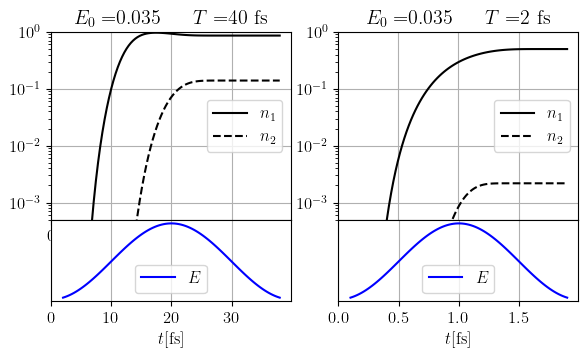

In [56]:
Ip_external = 3.37; A1 = 1.49
Ip_inner = 11.81; A2 = 1.83
w1 = IR(I = fs.eV_to_au(Ip_external), Z=0, l=1, m=0, A=A1)
w2 = IR(I = fs.eV_to_au(Ip_inner), Z=1, l=1, m=0, A=A2)

C_inner_fit_1d_coulomb = 0.857510464
C_external_fit_1d_short = 0.7443286218

w1.set_C_fit_1d_short(C_external_fit_1d_short)

w2.set_C_fit_1d_coulomb(C_inner_fit_1d_coulomb)

Ts = np.array([40, 2])
T = Ts/au_to_fs
omegas = np.pi/T
E0s = [0.035, 0.035]
Nt = 100

# задаем поле
def E(t, E0, omega):
    E = E0 * np.sin(omega * t) ** 2 * \
        np.heaviside(np.pi / omega - t, 0)
    return E


fig, ax = plt.subplots(2, 2, figsize=(6.8, 3.5), gridspec_kw={'height_ratios': [2.3, 1]})
fig.subplots_adjust(hspace=0)

for i in range(2):
    omega = omegas[i]
    E0 = E0s[i]
    T = np.pi/omega
    t_arr = np.linspace(0.05*T, 0.95*T, Nt)
   
    #---------------
    m = 0
    # n = KinEqs(t_arr, [1, 0, 0], E0, omega,  w1, w2)
    n = KinEqs_1d_short_coulomb(t_arr, [1, 0, 0], E0, omega,  w1, w2)
    ax[0, i].plot(t_arr*au_to_fs, n[:, 1], color='black', label=r'$n_1$', linestyle = '-')
    ax[0, i].plot(t_arr*au_to_fs, n[:, 2], color='black', label=r'$n_2$', linestyle = '--')
    ax[0, i].grid(); ax[0, i].legend(loc='center right');
    ax[0, i].set_title(r"$E_0 = $"+f"{E0}"+r"$~~~~~T = $"+f"{Ts[i]}"+" fs")
    ax[0, i].set_yscale('log')
    ax[0, i].set(xlabel=r'$t$[fs]')
    ax[0, 0].set_ylim([5e-4, 1])
    ax[0, 1].set_ylim([5e-4, 1])

    ax[1, i].plot(t_arr*au_to_fs, E(t_arr, E0, omega), color='blue', label=r'$E$', linestyle = '-')
    ax[1, i].set(xlabel=r'$t$[fs]')
    ax[i, 0].set_xticks([0, 10, 20, 30])
    ax[i, 1].set_xticks([0.0, 0.5, 1.0, 1.5])
    ax[1, 0].set_yticks([])
    ax[1, 1].set_yticks([])
    ax[1, i].grid(); ax[1, i].legend();

    # if i==1:
    #     # сохранение массивов для статьи
    #     root_data = "/home/denis/MEPhI/Аспирантура/Моя_статья/data"
        
    #     np.save(root_data + "/Fig3/n1_plot_b.npy", n[:, 1])
    #     np.save(root_data + "/Fig3/n2_plot_b.npy", n[:, 2])
    #     np.save(root_data + "/Fig3/t_plot_b.npy", t_arr*au_to_fs)
    #     np.save(root_data + "/Fig3/E_plot_b.npy", E(t_arr, E0, omega))
        
    
fig.savefig('NEW_concentrations_1D.png', bbox_inches='tight', dpi=600)

# Xe

W_inner_last= 1.0334498476858223e-05


ValueError: x and y must have same first dimension, but have shapes (1600,) and (800,)

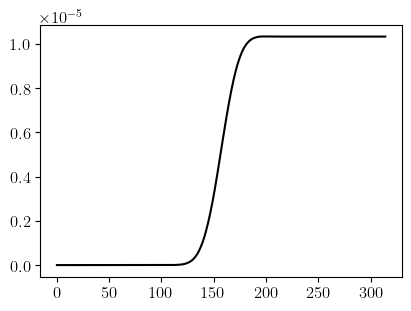

In [14]:
Ip_inner = 21.209; A1 = 1
Ip_external = 12.13; A2 = 1
C_inner_fit_1d_coulomb = 1.0082722557251316
C_external_fit_1d_coulomb = 0.8719712319784529

w_external = IR(I = fs.eV_to_au(Ip_external), Z=1, l=0, m=0, A=A1)
w_external.set_C_fit_1d_coulomb(C_external_fit_1d_coulomb)

w_inner = IR(I = fs.eV_to_au(Ip_inner), Z=2, l=0, m=0, A=A1)
w_inner.set_C_fit_1d_coulomb(C_inner_fit_1d_coulomb)

E0 = 0.045
omega = 0.01
Nt = 1000

t_num = np.load("/home/denis/RustSSFM/RSSFM2D/src/out/elf/Xe/RSSFM2D/src/out/inner/time_evol/t.npy")
with h5py.File("/home/denis/RustSSFM/RSSFM2D/src/out/elf/Xe/RSSFM2D/src/out/inner/ioniz_prob.hdf5", "r") as f:
    ioniz_prob = f["ioniz_prob_1"][:]

T = np.pi/omega
t_arr = np.linspace(0.001*T, 0.999*T, Nt)

n = KinEqs_1d_coulomb_single_ionization(t_arr, [1, 0], E0, omega, w_inner)
print("W_inner_last=", n[:, 1][-1])
fig, ax = plot([t_arr, t_num], [n[:,1], ioniz_prob], colors=["black", "red"], ylim=[1e-7, 1e-3])

n = KinEqs_1d_coulomb_single_ionization(t_arr, [1, 0], E0, omega, w_external)
print("W_external_last=", n[:, 1][-1])

n = KinEqs_1d_coulomb(t_arr, [1, 0, 0], E0, omega, w_external, w_inner)
print("DOUBLE_w_exter=", n[:,1][-1], "\nDOUBLE_w_inner=", n[:,2][-1])


# Ar18

In [16]:
Ip1 = 4120.4336; A1 = 1
Ip2 = 4426.474; A2 = 1
C_inner_fit_1d_coulomb = 75.34987766602039
C_external_fit_1d_coulomb = 68.047304627742

w_external = IR(I = fs.eV_to_au(Ip1), Z=17, l=0, m=0, A=A1)
w_inner = IR(I = fs.eV_to_au(Ip2), Z=18, l=0, m=0, A=A1)
w_inner.set_C_fit_1d_coulomb(C_inner_fit_1d_coulomb)
w_external.set_C_fit_1d_coulomb(C_external_fit_1d_coulomb)

E0 = 300
omega = 16
print("w_external: ", w_external.get_w_PPT(E0))
print("w_inner:    ", w_inner.get_w_PPT(E0))

print("1D_w_external: ", w_external.get_w_1d_coulomb(E0))
print("1D_w_inner:    ", w_inner.get_w_1d_coulomb(E0))

print("\nEcr_external: ", w_external.Ecr())
print("Ecr_inner: ", w_inner.Ecr())

print(f"\nIp_external: {fs.eV_to_au(Ip1)} au")
print(f"Ip_inner   : {fs.eV_to_au(Ip2)} au\n")

Nt = 100
T = np.pi/omega
t_arr = np.linspace(0.01*T, 0.99*T, Nt)
n = KinEqs_1d_coulomb_single_ionization(t_arr, [1, 0], E0, omega, w_inner)

n = KinEqs_1d_coulomb_single_ionization(t_arr, [1, 0], E0, omega, w_inner)
print("W_inner_last=", n[:, 1][-1])

n = KinEqs_1d_coulomb_single_ionization(t_arr, [1, 0], E0, omega, w_external)
print("W_external_last=", n[:, 1][-1])

n = KinEqs_1d_coulomb(t_arr, [1, 0, 0], E0, omega, w_external, w_inner)
print("DOUBLE_w_exter=", n[:,1][-1], "\nDOUBLE_w_inner=", n[:,2][-1])

w_external:  8.00883310735055e-06
w_inner:     2.346034510366889e-06
1D_w_external:  3.542894015046908
1D_w_inner:     1.4075759322502865

Ecr_external:  5270.36069496307
Ecr_inner:  5868.307125595615

Ip_external: 151.42476096268754 au
Ip_inner   : 162.6716584772902 au

W_inner_last= 0.04359570898270542
W_external_last= 0.11181636699465505
DOUBLE_w_exter= 0.1093118760350864 
DOUBLE_w_inner= 0.0025045159995574972


### Inner

w_last= 3.985916109220209e-05


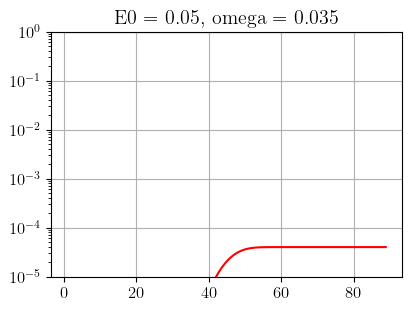

In [30]:
Nt = 1000
fig, ax = plt.subplots(1, 1, figsize=(4, 3), layout="constrained")
T = np.pi/omega
t_arr = np.linspace(0.01*T, 0.99*T, Nt)
n = KinEqs_1d_coulomb_single_ionization(t_arr, [1, 0], E0, omega, w_inner)
print("w_last=", n[:, 1][-1])
ax.plot(t_arr, n[:, 0], color="black", linestyle = '-')
ax.plot(t_arr, n[:, 1], color="red", linestyle = '-')
ax.grid();  
ax.set_title(f"E0 = {E0}, omega = {omega}")
ax.set_yscale('log')
ax.set_ylim([1e-5, 1]);
# ax.set_ylim([1e-10, 1])

### External

w_last= 0.013355454539089226


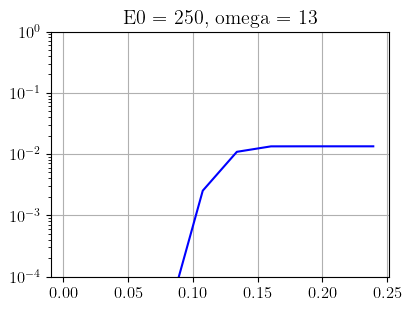

In [11]:
Nt = 10
fig, ax = plt.subplots(1, 1, figsize=(4, 3), layout="constrained")
T = np.pi/omega
t_arr = np.linspace(0.01*T, 0.99*T, Nt)
n = KinEqs_1d_coulomb_single_ionization(t_arr, [1, 0], E0, omega, w_external)
print("w_last=", n[:, 1][-1])
ax.plot(t_arr, n[:, 0], color="black", linestyle = '-')
ax.plot(t_arr, n[:, 1], color="blue", linestyle = '-')
ax.grid();  
ax.set_title(f"E0 = {E0}, omega = {omega}")
ax.set_yscale('log')
ax.set_ylim([1e-4, 1]);
# ax.set_ylim([1e-10, 1])

### Double

w_exter= 0.013329190752421545 w_inner= 2.626251930256551e-05


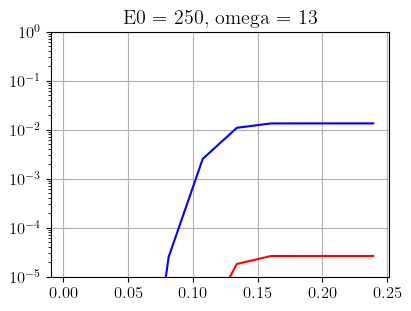

In [12]:
Nt = 10
fig, ax = plt.subplots(1, 1, figsize=(4, 3), layout="constrained")
T = np.pi/omega
t_arr = np.linspace(0.01*T, 0.99*T, Nt)
n = KinEqs_1d_coulomb(t_arr, [1, 0, 0], E0, omega, w_external, w_inner)
print("w_exter=", n[:,1][-1], "w_inner=", n[:,2][-1])
ax.plot(t_arr, n[:, 1], color="blue", linestyle = '-')
ax.plot(t_arr, n[:, 2], color="red", linestyle = '-')
ax.grid();  
ax.set_title(f"E0 = {E0}, omega = {omega}")
ax.set_yscale('log')
ax.set_ylim([1e-5, 1]);
# fig.savefig('w1w2_ms.png')

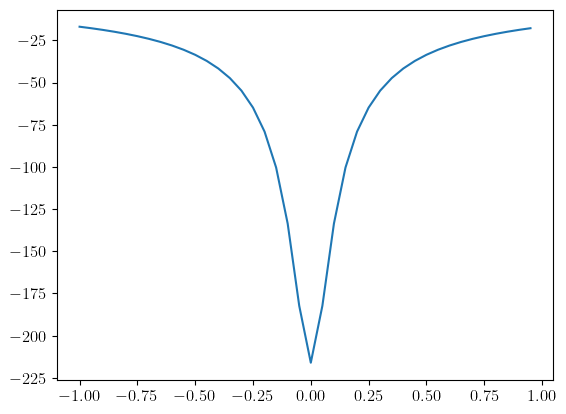

In [57]:
# Подбираем шаг сетки для разрешения потенциала
def atomic_potential(x, z, a):
    return z/np.sqrt(x**2+a**2)

dx = 0.05
z = -17
a = 0.0787

x = np.arange(-1, 1, dx)
plt.plot(x, atomic_potential(x, z, a))

# Ne10

In [9]:
Ip1 = 1195; A1 = 1
Ip2 = 1362; A2 = 1

w_external = IR(I = fs.eV_to_au(Ip1), Z=9, l=0, m=0, A=A1)
w_inner = IR(I = fs.eV_to_au(Ip2), Z=10, l=0, m=0, A=A1)

E = 50
print("w_external: ", w_external.get_w_PPT(E))
print("w_inner:    ", w_inner.get_w_PPT(E))

print("1D_w_external: ", w_external.get_w_1d_from_lower_state(E))
print("1D_w_inner:    ", w_inner.get_w_1d_from_lower_state(E))

print(f"\nIp_external: {fs.eV_to_au(Ip1)} au")
print(f"Ip_inner   : {fs.eV_to_au(Ip2)} au")

w_external:  0.0552601133606063
w_inner:     0.04247217481116242


TypeError: IR.get_w_1d_from_lower_state() takes 1 positional argument but 2 were given

# br

In [22]:
# br
Ip1 = 3.37; A1 = 1.49
Ip2 = 11.81; A2 = 1.83

## Different m

In [6]:
w1 = []
w2 = []
m1 = [0, 1,  1, -1, -1]
m2 = [0, 1, -1,  1, -1]
for i in range(len(m1)):
    w1.append(IR(I = fs.eV_to_au(Ip1), Z=0, l=1, m=m1[i], A=A1))
    w2.append(IR(I = fs.eV_to_au(Ip2), Z=1, l=1, m=m2[i], A=A2))

In [7]:
omegas = [0.002, 0.04]
E0s = [0.045, 0.035]
Nt = 100

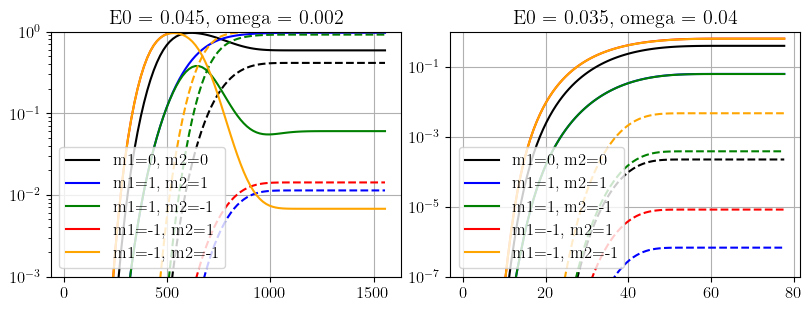

In [8]:
m_color = ['black', 'blue', 'green', 'red', 'orange']
m_label = ['m1=0, m2=0', 'm1=1, m2=1', 'm1=1, m2=-1', 'm1=-1, m2=1', 'm1=-1, m2=-1']
fig, ax = plt.subplots(1, 2, figsize=(8, 3), layout="constrained")
for i in range(2):
    omega = omegas[i]
    E0 = E0s[i]
    T = np.pi/omega
    t_arr = np.linspace(0.01*T, 0.99*T, Nt)
    for m in range(len(m1)):
        n = KinEqs(t_arr, [1, 0, 0], E0, omega, w1[m], w2[m])
        ax[i].plot(t_arr, n[:, 1], color=m_color[m], label=m_label[m], linestyle = '-')
        ax[i].plot(t_arr, n[:, 2], color=m_color[m], linestyle = '--')
    ax[i].grid(); ax[i].legend(); 
    ax[i].set_title(f"E0 = {E0}, omega = {omega}")
    ax[i].set_yscale('log')
    ax[0].set_ylim([1e-3, 1])
    ax[1].set_ylim([1e-7, 1])
# fig.savefig('w1w2_ms.png')

## m=0 to article

In [27]:
w1 = IR(I = fs.eV_to_au(Ip1), Z=0, l=1, m=0, A=A1)
w2 = IR(I = fs.eV_to_au(Ip2), Z=1, l=1, m=0, A=A2)

omegas = [0.002, 0.04]
E0s = [0.045, 0.035]
Nt = 100

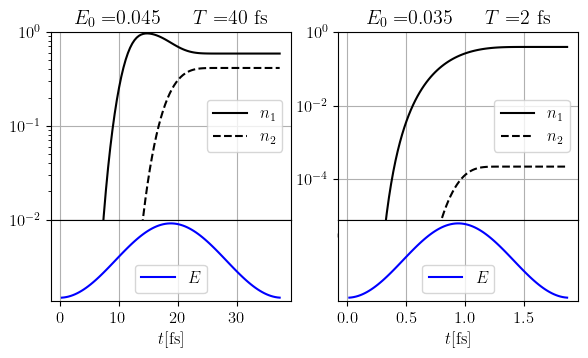

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(6.8, 3.5), gridspec_kw={'height_ratios': [2.3, 1]})
fig.subplots_adjust(hspace=0)
Ts = [40, 2]
for i in range(2):
    omega = omegas[i]
    E0 = E0s[i]
    T = np.pi/omega
    t_arr = np.linspace(0.01*T, 0.99*T, Nt)
    m = 0
    n = KinEqs(t_arr, [1, 0, 0], E0, omega, w1, w2)
    ax[0, i].plot(t_arr*au_to_fs, n[:, 1], color='black', label=r'$n_1$', linestyle = '-')
    ax[0, i].plot(t_arr*au_to_fs, n[:, 2], color='black', label=r'$n_2$', linestyle = '--')
    ax[0, i].grid(); ax[0, i].legend(loc='center right');
    ax[0, i].set_title(r"$E_0 = $"+f"{E0}"+r"$~~~~~T = $"+f"{Ts[i]}"+" fs")
    ax[0, i].set_yscale('log')
    ax[0, i].set(xlabel=r'$t$[fs]')
    ax[0, 0].set_ylim([1e-2, 1])
    ax[0, 1].set_ylim([8e-6, 1])

    ax[1, i].plot(t_arr*au_to_fs, E(t_arr, E0, omega), color='blue', label=r'$E$', linestyle = '-')
    ax[1, i].set(xlabel=r'$t$[fs]')
    ax[i, 0].set_xticks([0, 10, 20, 30])
    ax[i, 1].set_xticks([0.0, 0.5, 1.0, 1.5])
    ax[1, 0].set_yticks([])
    ax[1, 1].set_yticks([])
    ax[1, i].grid(); ax[1, i].legend();

    # if i==1:
    #     # сохранение массивов для статьи
    #     root_data = "/home/denis/MEPhI/Аспирантура/Моя_статья/data"
        
    #     np.save(root_data + "/Fig3/n1_plot_b.npy", n[:, 1])
    #     np.save(root_data + "/Fig3/n2_plot_b.npy", n[:, 2])
    #     np.save(root_data + "/Fig3/t_plot_b.npy", t_arr*au_to_fs)
    #     np.save(root_data + "/Fig3/E_plot_b.npy", E(t_arr, E0, omega))
        
    
# fig.savefig('concentrations_with_E.png', bbox_inches='tight', dpi=600)

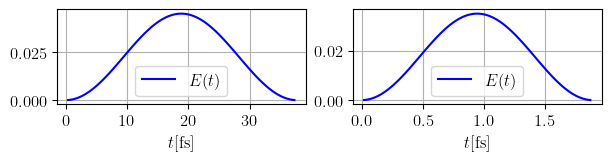

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 1.5), layout="constrained")
for i in range(2):
    omega = omegas[i]
    E0 = E0s[i]
    T = np.pi/omega
    t_arr = np.linspace(0.01*T, 0.99*T, Nt)
    ax[i].plot(t_arr*au_to_fs, E(t_arr, E0, omega), color='blue', label=r'$E(t)$', linestyle = '-')
    ax[i].grid(); ax[i].legend();
    ax[i].set(xlabel=r'$t$[fs]')
    ax[0].set_xticks([0, 10, 20, 30])
    ax[1].set_xticks([0.0, 0.5, 1.0, 1.5])
fig.savefig('E_for_concentrations.png')

[Text(0.5, 0, '$t$[fs]')]

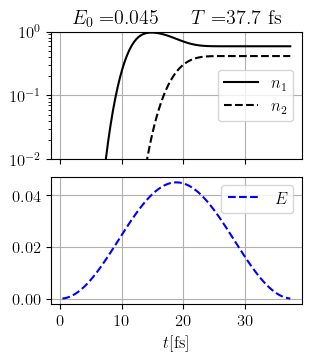

In [12]:
fig = plt.figure(figsize=(3, 3.5), layout="constrained")
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')

i=0
omega = omegas[i]
E0 = E0s[i]
T = np.pi/omega
t_arr = np.linspace(0.01*T, 0.99*T, Nt)
n = KinEqs(t_arr, [1, 0, 0], E0, omega, w1, w2)
ax1.plot(t_arr*au_to_fs, n[:, 1], color='black', label=r'$n_1$', linestyle = '-')
ax1.plot(t_arr*au_to_fs, n[:, 2], color='black', label=r'$n_2$', linestyle = '--')
ax1.grid(); ax[i].legend(loc='center right');
ax1.set_title(r"$E_0 = $"+f"{E0}"+r"$~~~~~T = $"+f"{np.pi/omega * au_to_fs:.1f}"+" fs")
ax1.set_yscale('log')
ax1.set_ylim([1e-2, 1])
ax1.legend(loc='center right');

ax2.plot(t_arr*au_to_fs, E(t_arr, E0, omega), color='blue', label=r"$E$", linestyle='--')
ax2.grid(); ax2.legend();
ax2.set(xlabel=r'$t$[fs]')
# for ax in fig.get_axes():
#     ax.label_outer()

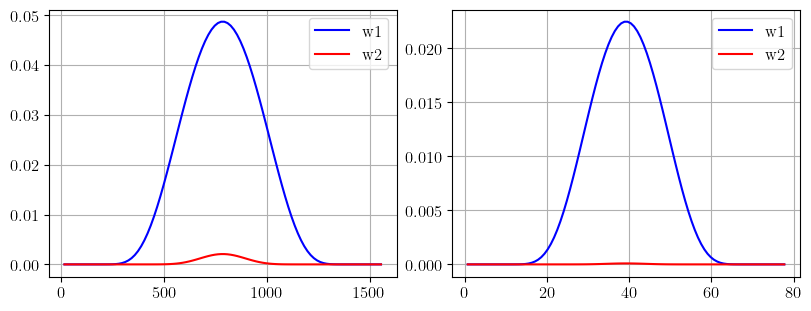

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), layout="constrained")
for i in range(2):
    omega = omegas[i]
    E0 = E0s[i]
    T = np.pi/omega
    t_arr = np.linspace(0.01*T, 0.99*T, Nt)
    ax[i].plot(t_arr, w1.get_w_PPT(E(t_arr, E0, omega)), label='w1', color='blue')
    # ax[i].plot(t_arr, w1.get_w_PPT_only_exp(E(t_arr, E0, omega)), label='w1', color='blue', linestyle='--')
    ax[i].plot(t_arr, w2.get_w_PPT(E(t_arr, E0, omega)), label='w2', color='red')
    # ax[i].plot(t_arr, w2.get_w_PPT_only_exp(E(t_arr, E0, omega)), label='w2', color='red', linestyle='--')
    ax[i].grid(); ax[i].legend();

## Saturation duration

In [7]:
w1 = IR(I = fs.eV_to_au(Ip1), Z=0, l=1, m=0, A=A1)
w2 = IR(I = fs.eV_to_au(Ip2), Z=1, l=1, m=0, A=A2)

In [8]:
tau_arr = np.linspace(0.5, 50, 50)  # fs
omega_arr = np.pi/tau_arr*au_to_fs  # au
E0s = [0.035, 0.045]
Nt = 100

In [9]:
def plot_n(n, n_only, E0, tau, i):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="constrained")
    ax.plot(t_arr*au_to_fs, n[:, 1], color='black', label=r'$n_1$', linestyle = '-')
    ax.plot(t_arr*au_to_fs, n_only[:, 1], color='blue', label=r'$n_1$ only', linestyle = '-.')
    ax.plot(t_arr*au_to_fs, n[:, 2], color='black', label=r'$n_2$', linestyle = '--')
    ax.grid(); ax.legend(loc='center right');
    ax.set_title(r"$E_0 = $"+f"{E0}"+r"$~~~~~T = $"+f"{tau:.1f}"+" fs")
    ax.set_yscale('log')
    ax.set(xlabel=r'$t$[fs]')
    ax.set_ylim([1e-2, 1])
    fig.savefig(f'n_E={E0}/fig{i}.png')
    plt.close()

In [10]:
n1_T2_data  = []
n1_max_data = []

n1_only_T2_data = []
n1_only_max_data = []

In [11]:
for k in range(len(E0s)):
    n1_T2 = np.zeros_like(tau_arr)
    n1_max = np.zeros_like(tau_arr)
    n1_only_T2 = np.zeros_like(tau_arr)
    n1_only_max = np.zeros_like(tau_arr)
    for i in range(len(tau_arr)):
        
        T = np.pi/omega_arr[i]
        t_arr = np.linspace(0.01*T, 0.99*T, Nt)
        
        n = KinEqs(t_arr, [1, 0, 0], E0s[k], omega_arr[i], w1, w2)
        n_only = KinEq_only_n0n1(t_arr, [1, 0], E0s[k], omega_arr[i], w1)
        
        plot_n(n, n_only, E0s[k], tau_arr[i], i)

        n1_max[i] = np.max(n[:, 1])  # в момент максимума поля
        n1_T2[i] = n[:, 1][Nt//2]  # максимальное значение
        n1_only_max[i] = np.max(n_only[:, 1])  # максимальное значение без второго электрона
        n1_only_T2[i] = n_only[:, 1][Nt//2]  # в момент максимума поля без второго электрона
    n1_T2_data.append(n1_T2)
    n1_max_data.append(n1_max)
    n1_only_T2_data.append(n1_only_T2)
    n1_only_max_data.append(n1_only_max)

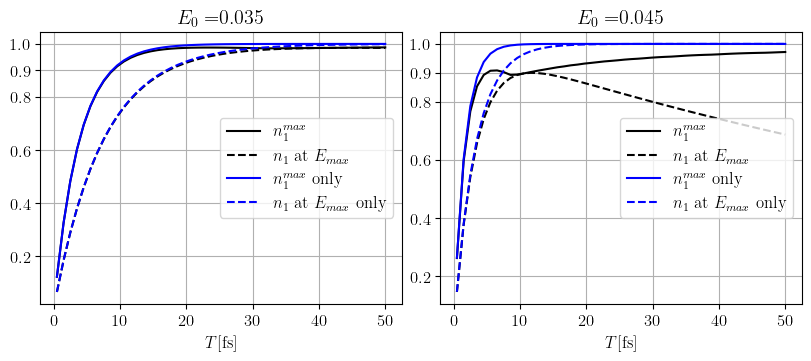

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), layout="constrained")
for i in range(2):
    ax[i].plot(tau_arr, n1_max_data[i], color='black', label=r'$n_1^{max}$', linestyle = '-')
    ax[i].plot(tau_arr, n1_T2_data[i], color='black', label=r'$n_1$ at $E_{max}$', linestyle = '--')
    ax[i].plot(tau_arr, n1_only_max_data[i], color='blue', label=r'$n_1^{max}$ only', linestyle = '-')
    ax[i].plot(tau_arr, n1_only_T2_data[i], color='blue', label=r'$n_1$ at $E_{max}$ only', linestyle = '--')
    ax[i].grid(); ax[i].legend(loc='center right');
    ax[i].set_title(r"$E_0 = $"+f"{E0s[i]}")
    ax[i].set_yticks([0.2, 0.4, 0.6, 0.8, 0.9, 1.0])
    ax[i].set(xlabel=r'$T$[fs]');
fig.savefig('saturations.png')

In [77]:
saturation = 0.9
for k in range(len(E0s)):
    for i in range(len(tau_arr)):
        if n1_T2_data[k][i] >= saturation:
            print(f"i={i}, E={E0s[k]}, n1_T2={n1_T2_data[k][i]:.2f}, T={tau_arr[i]}")
            break

i=169, E=0.035, n1_T2=0.90, T=17.26452905811623
i=109, E=0.045, n1_T2=0.90, T=11.312625250501002
